In [1]:
import torch as th
import pandas as pd
import re
import string
from tqdm import tqdm
import matplotlib.pyplot as plt
from NLPUtils.preprocessUtils import removeWord

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Iterable
from torch.utils.data import Dataset, DataLoader

class IMDBDatasetForTextClassifiation(Dataset):

    def __init__(self,file = None, removeWordFile = None, MAX_LEN = 30, train = True) -> None:
        super(IMDBDatasetForTextClassifiation, self).__init__()
        self.UNKTOKEN = '<unk>'
        self.maxlen = MAX_LEN
        if train:
            self.df = pd.read_csv(file, encoding='utf-8')[:40000]
            self.voc = set()
            self.voc.add(self.UNKTOKEN)
            with open(removeWordFile, 'r', encoding='utf-8') as f:
                self.removeWordList = [removeWord.replace('\n', '') for removeWord in f.readlines()]
            print(f'Constructing Vocabulary...')
            for sentence in tqdm(self.df['review']):
                self.voc.update(self.removeWord(removeWordList=self.removeWordList, sentence=self.preprocess(sentence)))
            print(f'Constructing Word2Index Table...')
            self.word2idx = {word : idx for idx, word in enumerate(self.voc)}
            self.idx2word = {idx : word for idx, word in enumerate(self.voc)}
            print('DONE!')
        else:
            self.df = pd.read_csv(file, encoding='utf-8')[40000:]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> th.Tensor:
        preprocessed_data = self.removeWord(removeWordList=self.removeWordList, sentence = self.preprocess(self.df['review'][index]))[:self.maxlen]
        while len(preprocessed_data) < self.maxlen:
            preprocessed_data.append(self.idx2word[self.word2idx[self.UNKTOKEN]])
        x = th.tensor([self.word2idx[word] for word in preprocessed_data], dtype=th.long)
        y = th.tensor([1.,0.], dtype=th.float32) if self.df['sentiment'][index] == 'positive' else th.tensor([0., 1.], dtype=th.float32)
        return x, y

    def preprocess(self, sentence):
        return str.translate(sentence, str.maketrans('','', string.punctuation)).lower().split()

    def removeWord(self, removeWordList: list, sentence : Iterable):
        for removeWord in removeWordList:
            sentence = list(filter(removeWord.__ne__,sentence))
        return sentence

In [3]:
csvFilePath = '../basic_dataset/IMDB/IMDB Dataset.csv'
stopWordFile = './NLPUtils/english.txt'
BATCH_SIZE = 32
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'

In [4]:
print(f'Using {DEVICE}')

Using cuda


In [5]:
trainDataset = IMDBDatasetForTextClassifiation(csvFilePath, removeWordFile=stopWordFile, train=True)
trainDataloader = DataLoader(trainDataset, batch_size=BATCH_SIZE)

Constructing Vocabulary...


100%|██████████| 40000/40000 [02:34<00:00, 258.66it/s]

Constructing Word2Index Table...
DONE!


In [6]:

from torch.nn import Module
class TextClassificationModel(Module):

    def __init__(self, voc_size, max_len) -> None:
        super(TextClassificationModel, self).__init__()
        self.max_len = max_len
        self.embeddingLayer = th.nn.EmbeddingBag(voc_size, 200)
        self.linear1 = th.nn.Linear(200 * max_len , 64)
        self.linear2 = th.nn.Linear(64, 2)
    
    def forward(self, x):
        x = self.embeddingLayer(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x


In [7]:
model = TextClassificationModel(len(trainDataset.voc), max_len=trainDataset.maxlen).to(DEVICE)
loss_fn = th.nn.CrossEntropyLoss()
opti = th.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
epochs = []
losses = []
for epoch in range(20):
    for x,y in tqdm(trainDataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opti.step()
        loss_value = loss.item()
    epochs.append(epoch+1)
    losses.append(loss_value)


100%|██████████| 1250/1250 [02:52<00:00,  7.26it/s]


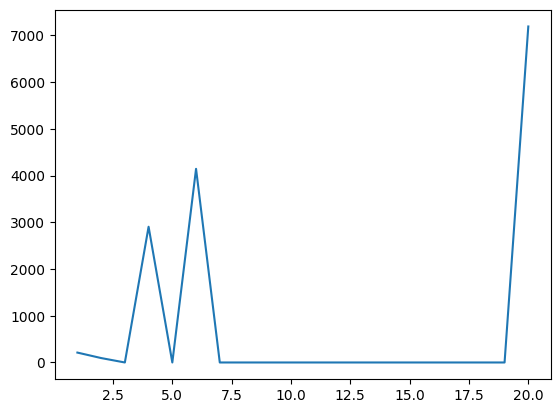

In [9]:
plt.plot(epochs, losses)
plt.show()

In [10]:
losses

[211.7429656982422,
 94.77604675292969,
 -0.0,
 2905.773193359375,
 -0.0,
 4145.228515625,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 7192.4521484375]